# Random Forest Classifier

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from utils import db_connect


# Pulling the dataframe from the database

engine = db_connect()
main_econ_df = pd.read_sql('SELECT * FROM main_econ_view', con=engine)

Connection successful


In [ ]:
# Checking columns
main_econ_df.columns

Index(['NCESSCH', 'SURVYEAR', 'LEAID', 'LEA_NAME', 'SCH_NAME', 'CHARTER_TEXT',
       'MAGNET_TEXT', 'TOTFRL', 'FRELCH', 'REDLCH', 'PK', 'KG', 'G01', 'G02',
       'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12',
       'G13', 'UG', 'TOTAL', 'FTE', 'STUTERATIO', 'AM', 'AS', 'BL', 'HP', 'HI',
       'TR', 'WH', 'LATCOD', 'LONCOD', 'locale_category', 'TITLEI_GROUPED',
       'high_strain', 'TH_10_15K', 'TH_15_25K', 'TH_WITH_CASH_ASSIST',
       'TH_100_150K', 'TH_LT_10K', 'BPL_ALL_FAM', 'TH_50_75K', 'TH_75_100K',
       'TH_25_35K', 'TH_150_200K', 'TH_35_50K', 'TH_WITH_SNAP', 'BPL_ALL',
       'TH_200K_AND_ABOVE', 'econ_rolling_year_period'],
      dtype='str')

## PREPARING FEATURES

In [ ]:
# Copying the dataframe to not screw up the original dataframe
df = main_econ_df.copy()

# Dropping THE BAD columns that may be unnecessary or could potentially cause data leakage
drop_cols = ["NCESSCH", 'LEAID', "LEA_NAME", "SCH_NAME", "LATCOD", "LONCOD", "STUTERATIO", "FTE", "TOTAL"]

df = df.drop(columns=drop_cols)

In [ ]:
# Dropping the target variable from the columns and assigning to x
x = df.drop(columns=["high_strain"])

# Assigning the target variable to y
y = df["high_strain"]



In [ ]:
# Checking the balance of the dataset (HIGHLY UNBALANCED)
print(y.value_counts())

high_strain
0    163664
1     15011
Name: count, dtype: int64


In [ ]:
# Turning categorical values into numerical values for the model to have a good time
x = pd.get_dummies(x, drop_first=True)

## TRAIN-TEST SPLIT

In [6]:
from sklearn.model_selection import train_test_split


# stratify = y ensures that training and test are proportional to the target var
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, make_scorer

# Class weight assign weights to different classes
randomForest = RandomForestClassifier(
    n_estimators = 200,
    max_depth=None,
    random_state=42, class_weight="balanced"
)

# Fitting the random forest model
randomForest.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Evaluate the Model

Testing the metrics for the most optimal treshold based on the F1 value (harmonic mean of precision and recall)

In [44]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Recall low, adjusting the pred
y_proba = randomForest.predict_proba(x_test)[:,1] # The probability of being strained 

# Arrange thresholds
thresholds = np.arange(0.20, 0.60, 0.05)

# 
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    print(
        f"Threshold {t:.2f}  "
        f"Precision: {precision_score(y_test, preds):.3f}  "
        f"Recall: {recall_score(y_test, preds):.3f}  "
        f"F1: {f1_score(y_test, preds):.3f}  "
        f"ROC AUC: {roc_auc_score(y_test, y_proba)} "
    )


Threshold 0.20  Precision: 0.566  Recall: 0.742  F1: 0.642  ROC AUC: 0.9346506294554126 
Threshold 0.25  Precision: 0.633  Recall: 0.687  F1: 0.659  ROC AUC: 0.9346506294554126 
Threshold 0.30  Precision: 0.683  Recall: 0.618  F1: 0.649  ROC AUC: 0.9346506294554126 
Threshold 0.35  Precision: 0.723  Recall: 0.553  F1: 0.627  ROC AUC: 0.9346506294554126 
Threshold 0.40  Precision: 0.763  Recall: 0.491  F1: 0.597  ROC AUC: 0.9346506294554126 
Threshold 0.45  Precision: 0.800  Recall: 0.429  F1: 0.559  ROC AUC: 0.9346506294554126 
Threshold 0.50  Precision: 0.846  Recall: 0.367  F1: 0.512  ROC AUC: 0.9346506294554126 
Threshold 0.55  Precision: 0.875  Recall: 0.306  F1: 0.454  ROC AUC: 0.9346506294554126 


In [45]:
# Predict using .25 threshold 
y_pred = (y_proba > 0.25).astype(int) 


In [ ]:
# Running a feature importance check
from sklearn.inspection import permutation_importance

result = permutation_importance(
    randomForest,
    x_test,
    y_test,
    n_repeats=3,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

perm_importance = pd.DataFrame({
    "feature": x_test.columns,
    "importance": result.importances_mean
    
}).sort_values(by="importance", ascending=False)

print(perm_importance.head(15))

# The importance value is based on the "roc_auc". WH for example reduces ranking ability by .017825 AUC if the variable is destroyed. Essentially shuffling the value of WH to randomly assigned schools, destroying the relationship between WH and strain.

                feature  importance
26                   WH    0.017825
40    TH_200K_AND_ABOVE    0.009231
0              SURVYEAR    0.007262
38         TH_WITH_SNAP    0.007147
4                    PK    0.006547
29  TH_WITH_CASH_ASSIST    0.006431
22                   BL    0.006081
33            TH_50_75K    0.005673
19                   UG    0.005497
30          TH_100_150K    0.005438
24                   HI    0.005240
35            TH_25_35K    0.005040
6                   G01    0.004798
34           TH_75_100K    0.004502
36          TH_150_200K    0.004493


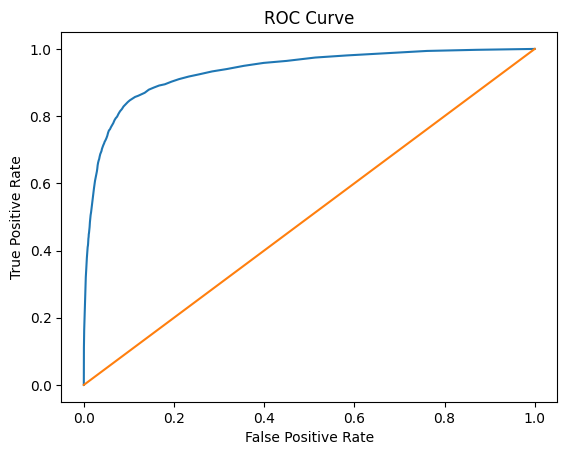

In [ ]:
# Graphing the ROC Curve 

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_prob = randomForest.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1])  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# X-axis represent the percentage of non-strained schools incorrectly flagged as strained.
# Y-axis represnet the percentage of strained schools correctly identified
# The linear orange line represent random guessing.
# Essentially the graph shows that there's a strong separation, the model can classify strain in a way that matters and is not by chance.

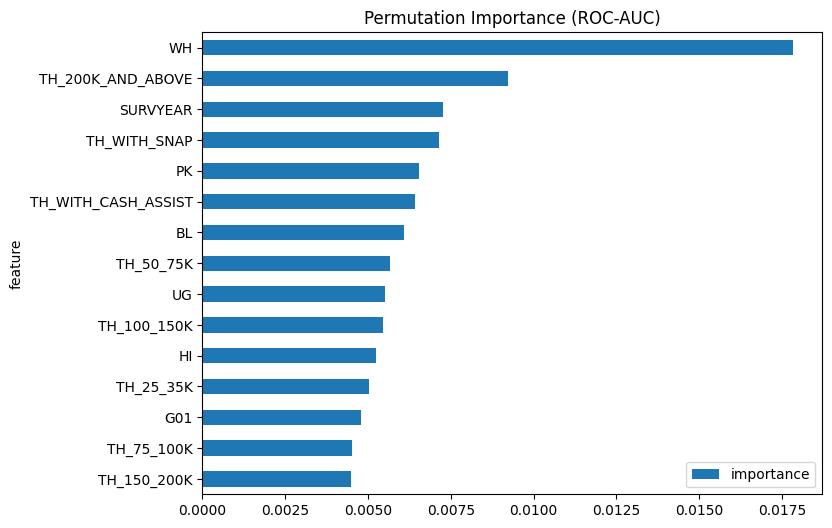

In [ ]:
# Representing feature importance in a bar graph
perm_importance.head(15).plot.barh(
    x="feature",
    y="importance",
    figsize=(8,6)
)
plt.gca().invert_yaxis()
plt.title("Permutation Importance (ROC-AUC)")
plt.show()

# The larger the bar, the larger the performance, which also means the larger the model reliance on this feature.

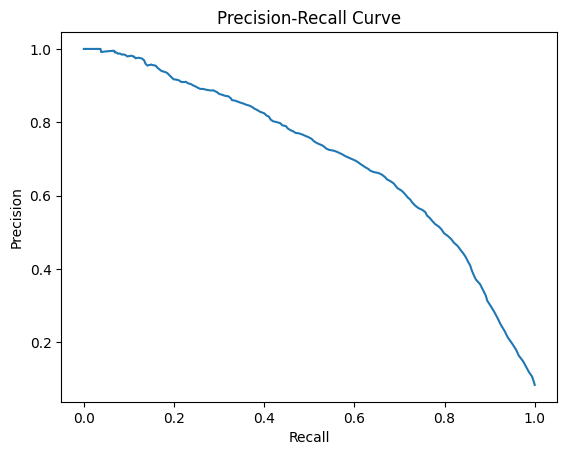

In [ ]:
# Graphing precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# X-axis is basically of all strained schools, how many can be caught
# Y-axis of the schools flagged as strained, how many are actually strained
# With such a highly imbalanced data, with 8.4% being positve class, accuracy becomes useless. So ROC_AUC can look strong even if precision is mediocre, making precision-recall curve very important.
# If randomaly label schools as strained, you'd only be right about 8.4% of the time.

In [ ]:
# Average precision
from sklearn.metrics import average_precision_score
print("Average Precision:", average_precision_score(y_test, y_prob))

# Excellent precision as .7+. Area under the precision-recall curve. Across thresholds, the model maintains high precision while increasing recall. 

Average Precision: 0.701306738368102


In [56]:
# Classificaiton Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     32733
           1       0.64      0.68      0.66      3002

    accuracy                           0.94     35735
   macro avg       0.80      0.82      0.81     35735
weighted avg       0.94      0.94      0.94     35735



# Sanity Check
I believe that the grades is disproportionately affecting the model as adding them up can lead to the total students. So we will remove the grades and rerun the model to see if it's true.

In [ ]:
# Checking the columns
df.columns

Index(['SURVYEAR', 'CHARTER_TEXT', 'MAGNET_TEXT', 'TOTFRL', 'FRELCH', 'REDLCH',
       'PK', 'KG', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08',
       'G09', 'G10', 'G11', 'G12', 'G13', 'UG', 'AM', 'AS', 'BL', 'HP', 'HI',
       'TR', 'WH', 'locale_category', 'TITLEI_GROUPED', 'high_strain',
       'TH_10_15K', 'TH_15_25K', 'TH_WITH_CASH_ASSIST', 'TH_100_150K',
       'TH_LT_10K', 'BPL_ALL_FAM', 'TH_50_75K', 'TH_75_100K', 'TH_25_35K',
       'TH_150_200K', 'TH_35_50K', 'TH_WITH_SNAP', 'BPL_ALL',
       'TH_200K_AND_ABOVE', 'econ_rolling_year_period'],
      dtype='str')

In [54]:
# Removing grades to double check if the model still works well and re running the model.

grade_cols = [
    "PK","KG","G01","G02","G03","G04","G05",
    "G06","G07","G08","G09","G10","G11","G12","G13","UG"
]

x_reduced = x.drop(columns=grade_cols)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(
    x_reduced, y, test_size=0.2, random_state=42, stratify=y
)

rf_reduced = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_reduced.fit(x_train_r, y_train_r)

y_prob_r = rf_reduced.predict_proba(x_test_r)[:,1]

print("Reduced ROC-AUC:", roc_auc_score(y_test_r, y_prob_r))
print("Reduced Average Precision:", average_precision_score(y_test_r, y_prob_r))

# The ROC-AUC value barely drops meaning that the enrollment size was help but not the main driver for the results. This confirms that the model is still identifying strain classification quite well, showing that socioeconomic and demographic structure has more of a role to play in strain than enrollment size.

Reduced ROC-AUC: 0.9201423279499631
Reduced Average Precision: 0.6519241925383803


Despite the slight dips in ROC-AUC and average precision values, the values are still relatively stable despite dropping the grade columns.

# Need to Work on the findings
Pretty much, the model is actually a lot better than guessing when it comes to reliably ranking strained above non strained schools with a ROC-AUC of .93. Despite the class imbalance, with the number of strained schools comprising of roughly 8.4% of the dataset, the model predicts concentrates true high strained schools among predicted high strained schools better than chance. With the choice of .25 being the threshold, this was decided as the F1 value or the harmonic value was the highest out of the thresholds tested. Essentially, the lower the recall, the higher the precision, and vice versa, thus it was necessary to find the right balance between the two in an objective sense. The top contributors to the model was WH, TH_200K_AND_ABOVE, SURVYEAR, etc. Additionally, sanity checks prove that although the grade levels have an impact on the model, it does not disproportionately affect the model extremely compared to other columns. Overall, the model suggests that strain is associated with socioeconomic structure and demographic compositions. (Strain)
